In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
import hdbscan
%matplotlib inline
from filter_data import *
from syn_model import *
from load_and_clean import *
from cycler import cycler

import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")


## Loading data

In [4]:
#update_data()
#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple = load_clean('mobility Apple')
mobility_data_google, google_social = load_clean('mobility Google')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

ctp_us_data = load_clean('CTP US')
ctp_state_data = load_clean('CTP states')
ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'West Bank and Gaza', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [5]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


last date
Exceptions are []


## Set up possible donors

In [7]:
#collect donors pool which consist the counties in cluster_2_state with long spreading time 
#cluster_2_states = no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii

cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

## Train model with different singular values

In [9]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']

models = []

for singVals in range(1,10):

    target_model = []
    cluster_2_model = []

    #print("Intervention date: ", testDF.index[0])
    for state in targets:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        if state in otherStates:
            otherStates.remove(state)


        rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel.fit_model()
        target_model.append(rscModel)

        predictions = rscModel.predictions
        model_fit = rscModel.model_fit

        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]

        if new_state in otherStates:
            otherStates.remove(new_state)

        rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel2.fit_model()
        cluster_2_model.append(rscModel2)

        predictions = rscModel2.predictions
        model_fit = rscModel2.model_fit
    
    models.append((target_model, cluster_2_model)) #Storing both the model for noreasther state and our target state


Analysis for state Broward-Florida
theory singular value in range 7.6 to 10.9


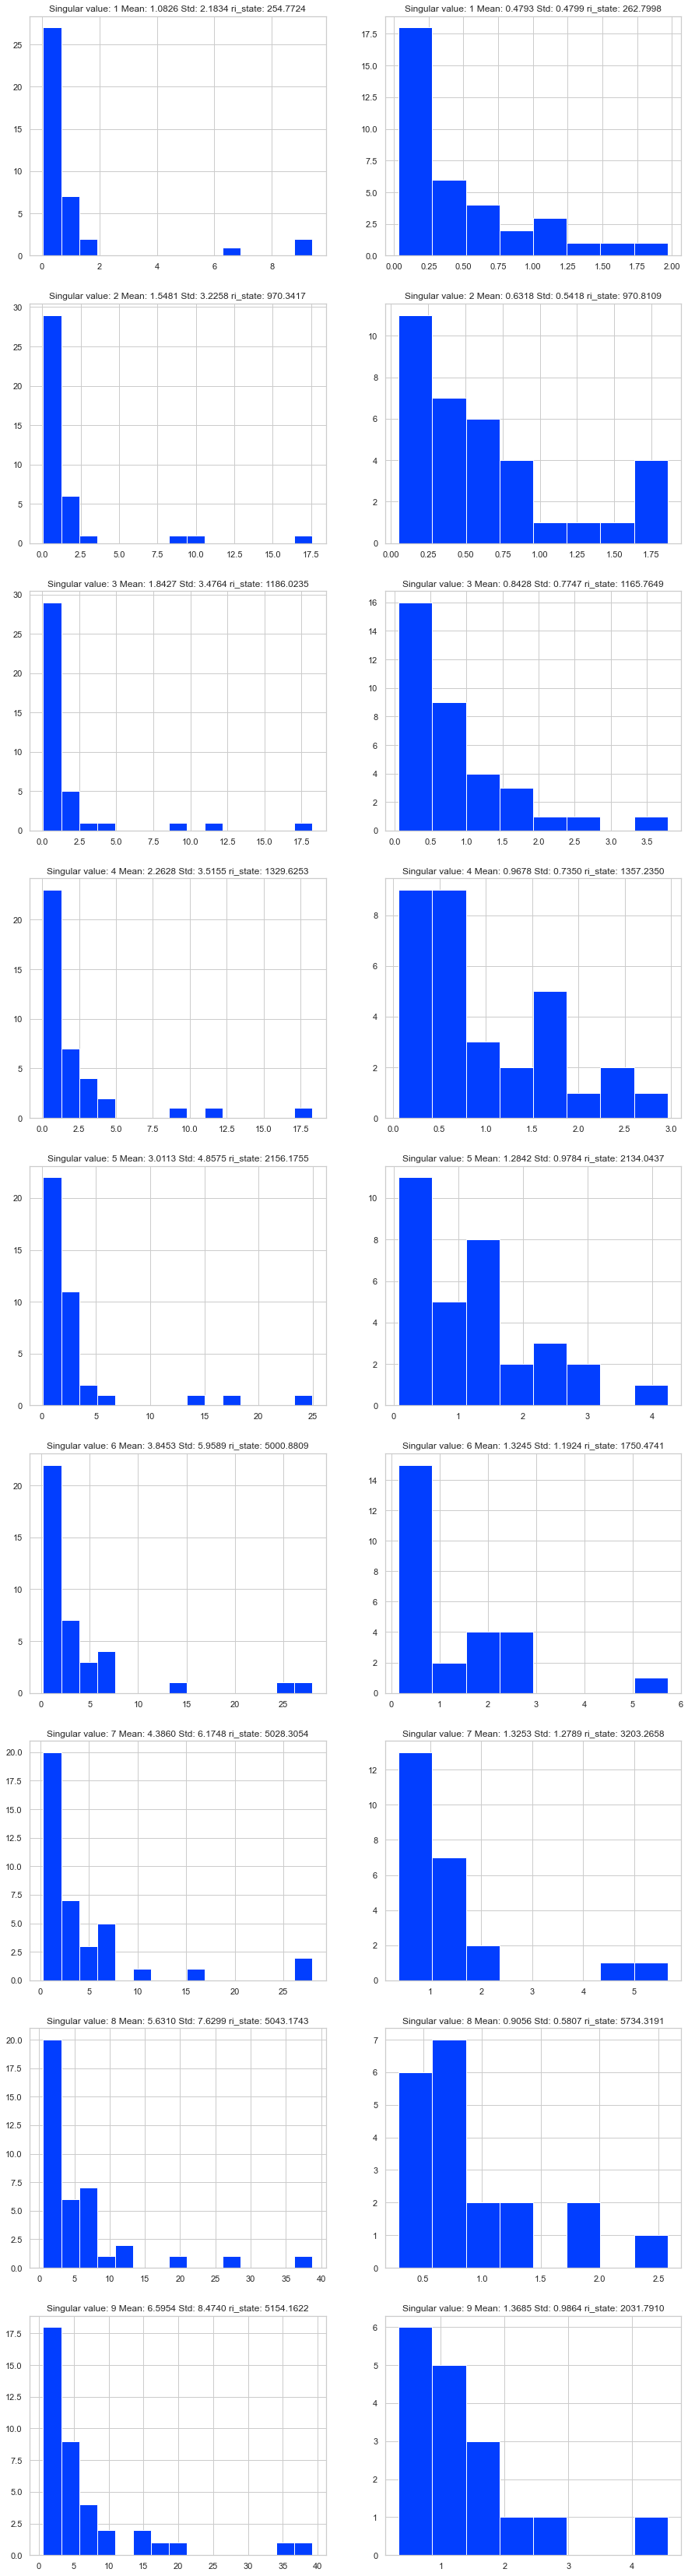

In [18]:
fig, axes = plt.subplots(len(models), 2, figsize = (15, 60))
c = 3 #the cut off wgen generating new donor pool
old = np.empty((len(models), 2))
new = np.empty((len(models), 2))

stat_index = 1 #The index of the state we are plotting in the target list

new_model_list = []
print("Analysis for state %s"%(models[0][0][stat_index].state))
p = 0.95
X = models[0][0][stat_index].train[models[0][0][stat_index].state]
b = max(X)
a = min(X)
X = (X - (a + b)/2)/(b-a)/2
variance = np.var(X, ddof = 1)
l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 
                                                              # https://www.jmlr.org/papers/volume19/17-777/17-777.pdf

for i in range(len(models)):
    perm_dict = models[i][0][stat_index].permutation_distribution(show_graph = False)
    old[i][1] = perm_dict.pop(models[i][0][stat_index].state)
    
     
    selected = np.array(list(perm_dict.values()))
    old[i][0] = np.mean(selected)
    axes[i][0].hist(selected, bins = 15)
    axes[i][0].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(selected), np.std(selected), models[i][0][stat_index].find_ri()))
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]

    new_model = syn_model(models[i][0][stat_index].state,  models[i][0][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_model_list.append(new_model)
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())
    new[i][0] = np.mean(values)

    axes[i][1].hist(values, bins = 8)
    axes[i][1].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(values), np.std(values), new_model.find_ri()))

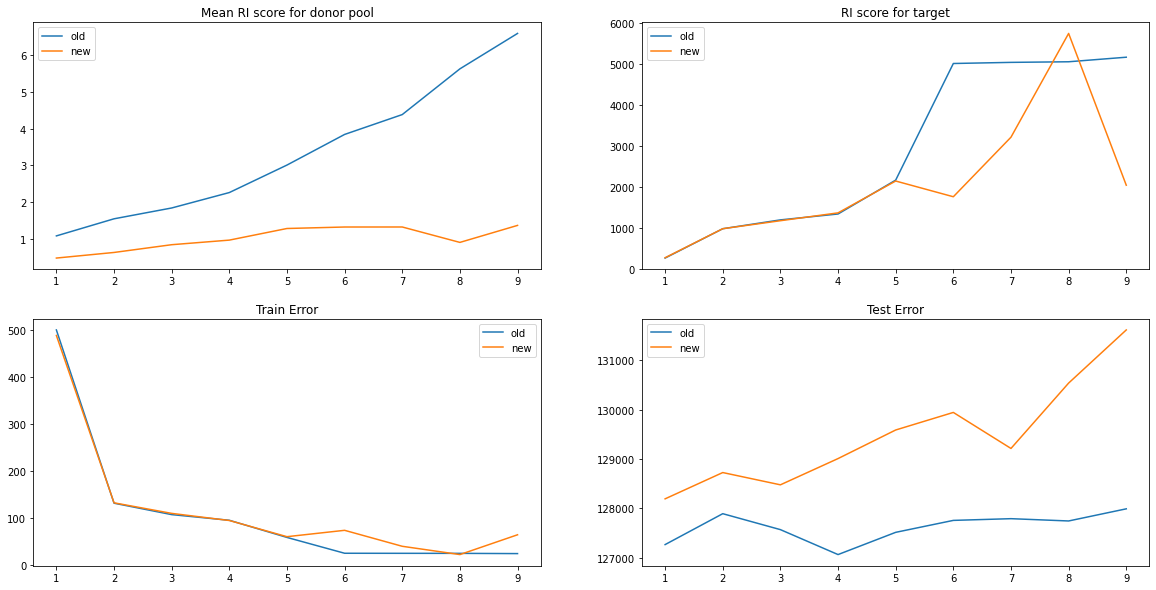

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))
axes[0][0].plot(range(1, len(old.T[0]) + 1), old.T[0], label = 'old')
axes[0][0].plot(range(1, len(new.T[0]) + 1), new.T[0], label = 'new')
axes[0][0].set_title('Mean RI score for donor pool')
axes[0][0].legend()

axes[0][1].plot(range(1, len(old.T[1]) + 1), old.T[1], label = 'old')
axes[0][1].plot(range(1, len(new.T[1]) + 1), new.T[1], label = 'new')
axes[0][1].set_title('RI score for target')
axes[0][1].legend()

old_train_error = [m[0][stat_index].train_err for m in models]
old_test_error = [m[0][stat_index].test_err for m in models]

new_train_error = [m.train_err for m in new_model_list]
new_test_error = [m.test_err for m in new_model_list]

axes[1][0].plot(range(1, len(old.T[0]) + 1), old_train_error, label = 'old')
axes[1][0].plot(range(1, len(new.T[0]) + 1), new_train_error, label = 'new')
axes[1][0].set_title('Train Error')
axes[1][0].legend()


axes[1][1].plot(range(1, len(old.T[1]) + 1), old_test_error, label = 'old')
axes[1][1].plot(range(1, len(new.T[1]) + 1), new_test_error, label = 'new')
axes[1][1].set_title('Test Error')
axes[1][1].legend()